<a href="https://colab.research.google.com/github/Koushikl0l/StockHound/blob/main/Demo_Predicting_NEPSE_Index_Price_Using_Deep_Learning_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
/content/drive/MyDrive/NEPSE/input_data.csv

In [ ]:
import os
import time
import math
import ast
import warnings
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten
from tensorflow.keras import optimizers

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from numpy.linalg import eig


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/NEPSE/input_data.csv')
output_dir_path = '/content/drive/MyDrive/NEPSE/'
data['Date']=pd.to_datetime(data['Date']).dt.date
data.set_index("Date",inplace=True)
data.head()

,Unnamed: 0,Open,High,Low,Close,Volume,MACD,RSI,ATR,MFI,CPI,USDX,IR,TB,EFFR,RMT,Score
Date,,,,,,,,,,,,,,,,,
2016-07-17,0,1718.15,1749.96,1715.14,1745.74,2272045,-37.509420,74.940143,23.122890,70.196510,112.9,107.519,8.6,0.44,0.82,51.94,0.20955
2016-07-18,1,1745.74,1786.68,1745.74,1786.59,2870497,-41.071885,82.962838,24.395540,67.197424,112.9,107.519,8.6,0.44,0.82,51.94,0.21927
2016-07-19,2,1786.59,1813.42,1785.33,1800.47,2902127,-44.502170,84.862752,24.659430,65.486818,112.9,107.519,8.6,0.44,0.82,51.94,-0.02642
2016-07-20,3,1800.47,1813.44,1782.57,1786.84,3474801,-45.595275,75.342839,25.103042,55.037084,112.9,107.519,8.6,0.44,0.82,51.94,0.15107
2016-07-21,4,1786.84,1804.75,1779.71,1798.83,3154492,-46.888559,77.863404,25.098539,67.326060,112.9,107.519,8.6,0.44,0.82,51.94,0.12900


**Explanation of Key Concepts:**

Moving Average (MA):
The NEPSE close price and both the moving averages (20-day and 50-day) are plotted on the same graph to visualize how the moving averages interact with the actual stock price.


The moving averages help identify trends, with the shorter-term 20-day MA reacting more quickly to price changes compared to the 50-day MA, which shows broader market trends.

1.   MA_20: A 20-day simple moving average that smooths out short-term fluctuations in the data over a 20-day period.

2.   MA_50: A 50-day simple moving average that is used to understand longer-term trends in stock price data.


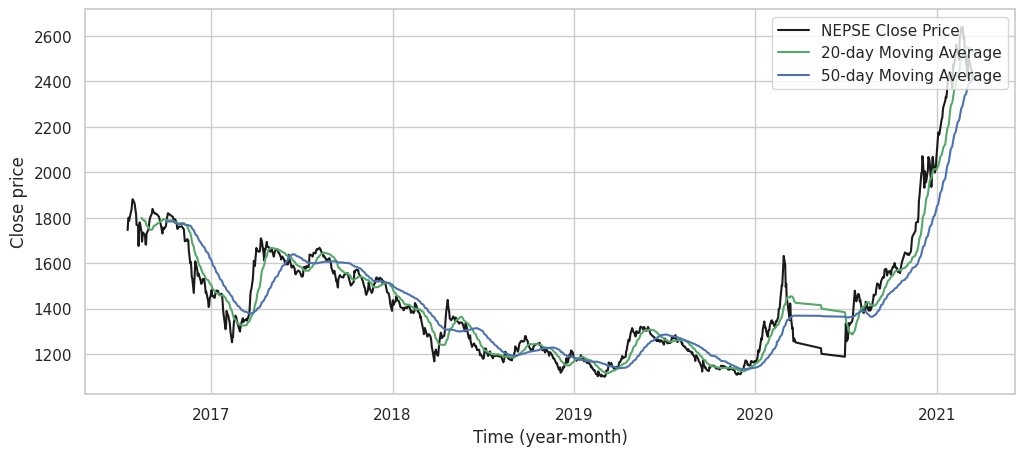

In [ ]:
df = data.copy()
#fig = plt.figure(figsize = (15,4))
df['MA_20'] = df['Close'].rolling(20).mean()
df['MA_50'] = df['Close'].rolling(50).mean()


fig = plt.figure(figsize=(12,5))
fig.set(facecolor = "white")
plt.plot(df['Close'], 'k',label=['NEPSE Close Price'])
plt.plot(df['MA_20'],'g', label=['20-day MA'])
plt.plot(df['MA_50'],'b', label=['50-day MA'])

plt.legend(['NEPSE Close Price', '20-day Moving Average', '50-day Moving Average'], loc='upper right')
plt.title('')
plt.xlabel('Time (year-month)')
plt.ylabel('Close price')

fig.savefig(output_dir_path+'original_data_plus_moving_averages.png',dpi=800)
plt.show()

In [ ]:
#df['MA_20'][:20],df['MA_50'][:50]

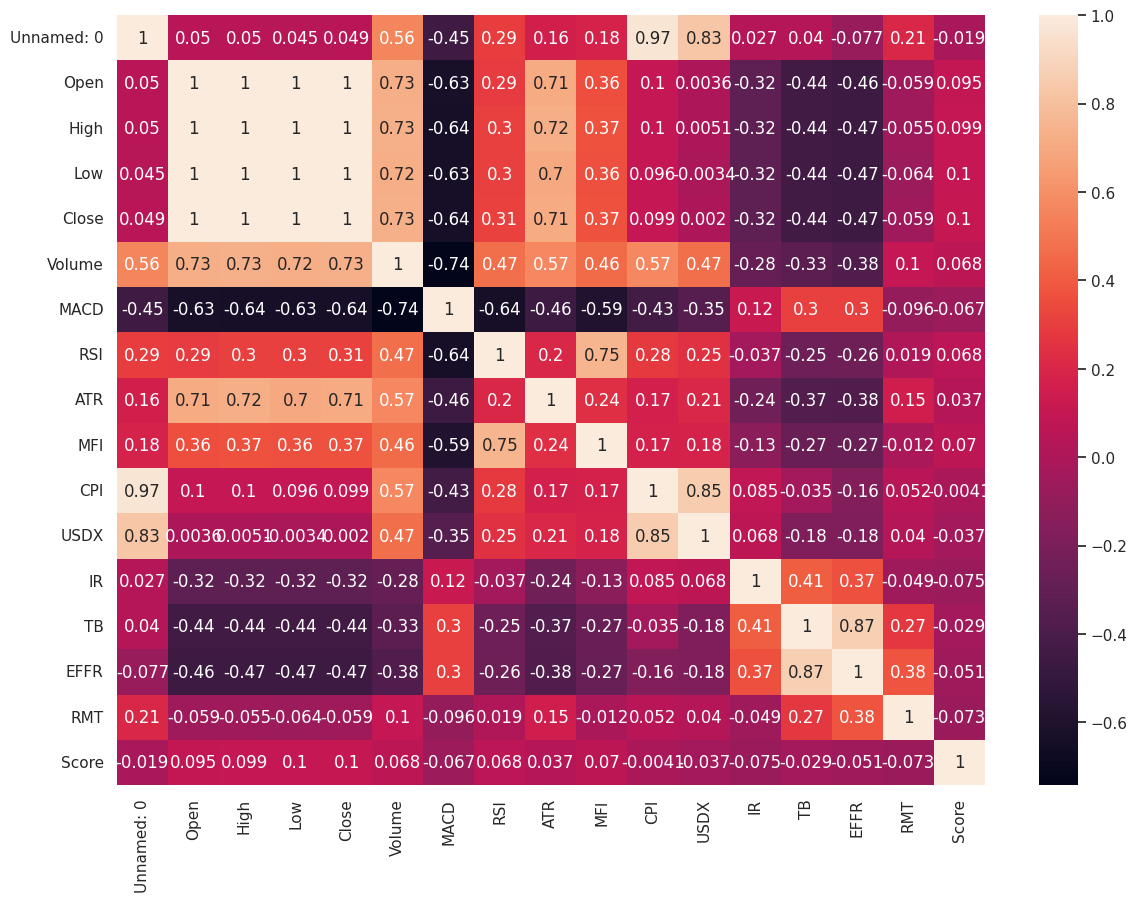

In [ ]:
fig = plt.figure(figsize= (14,10))
sns.heatmap(data.corr(), annot=True)
sns.set_style("whitegrid")

fig.savefig(output_dir_path+"correlation_heatmap.pdf",dpi=600)

In [ ]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import ast

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).

    Parameters:
    y_true: Actual values
    y_pred: Predicted values

    Returns:
    MAPE: The average percentage difference between the true and predicted values.
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to calculate evaluation metrics (RMSE, Correlation Coefficient, MAPE)
def calculate_scores(y_true, y_pred):
    """
    Calculate different evaluation metrics like RMSE, Pearson correlation coefficient (R), and MAPE.

    Parameters:
    y_true: Actual values
    y_pred: Predicted values

    Returns:
    A dictionary containing:
    - rmse: Root Mean Squared Error
    - R: Pearson correlation coefficient
    - mape: Mean Absolute Percentage Error
    """
    # Root Mean Squared Error
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))

    # Pearson Correlation Coefficient
    R = np.corrcoef(y_true, y_pred)[0, 1]

    # Mean Absolute Percentage Error
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Returning the calculated metrics in a dictionary
    return {'rmse': rmse, 'R': R, 'mape': mape}

# Function to create time-series dataset for supervised learning
def DatasetCreation(dataset, time_step=1):
    """
    Create sequences from time-series data, where each sequence of 'time_step' length is used to predict the next value.

    Parameters:
    dataset: Time-series data
    time_step: Number of previous time steps to include in each input sequence (default is 1)

    Returns:
    DataX: Array of input sequences
    DataY: Array of corresponding output values
    """
    DataX, DataY = [], []

    # Create sliding window sequences
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), ]  # Extract sequence of 'time_step' length
        DataX.append(a)  # Append the input sequence
        DataY.append(dataset[i + time_step, 0])  # Append the corresponding output (next time step)

    return np.array(DataX), np.array(DataY)

def split_data(data, test_size=0.2):
    """
    Split the dataset into training and testing sets.

    Parameters:
    data: The complete dataset (e.g., a pandas DataFrame)
    test_size: Proportion of the data to be used for testing (default is 0.2 or 20%)

    Returns:
    train_data: Training set
    test_data: Testing set
    """
    # Determine the index at which to split the data
    split_index = int(len(data) * (1 - test_size))

    # Split the dataset into training and testing sets
    train_data = data.iloc[:split_index, :]  # Training set from the start to the split index
    test_data = data.iloc[split_index:, :]   # Testing set from the split index to the end

    return train_data, test_data


# Function to apply Min-Max scaling to the data
def min_max_transform(data, feature_range=(0, 1)):
    """
    Apply Min-Max scaling to the data to scale features to a given range.

    Parameters:
    data: Data to be scaled
    feature_range: The desired range for scaling (default is 0 to 1)

    Returns:
    Scaled data
    """
    scaler = MinMaxScaler(feature_range)  # Initialize the Min-Max Scaler
    return scaler.fit_transform(data)  # Fit and transform the data

# Function to reverse the Min-Max scaling
def min_max_inverse_transform(data_scaled, min_original, max_original):
    """
    Perform the inverse transformation of Min-Max scaling, converting scaled data back to its original range.

    Parameters:
    data_scaled: Scaled data
    min_original: Minimum value of the original data
    max_original: Maximum value of the original data

    Returns:
    Original data in its original range
    """
    return min_original + data_scaled * (max_original - min_original)

# Function to write a dictionary to a file
def write_dic_to_file(dic_name, file_name):
    """
    Write a dictionary to a file.

    Parameters:
    dic_name: Dictionary to be written
    file_name: Name of the file where the dictionary will be saved
    """
    with open(file_name, 'w') as file:
        file.write(str(dic_name))  # Convert the dictionary to a string and write it to the file

# Function to read a dictionary from a file
def read_dic_from_file(file_name):
    """
    Read a dictionary from a file.

    Parameters:
    file_name: Name of the file containing the dictionary

    Returns:
    dictionary: The dictionary read from the file
    """
    with open(file_name, 'r') as file:
        contents = file.read()  # Read the file contents
        dictionary = ast.literal_eval(contents)  # Convert the string back to a dictionary

    return dictionary


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import optimizers
import numpy as np

def build_lstm_model(layers, time_steps, num_features, optimizer='Adam', learning_rate=0.001, verbose=1):
    """
    Build and compile an LSTM model based on the given configuration.

    Parameters:
    layers: List of integers representing the number of units in each LSTM layer.
    time_steps: The number of time steps for the input data.
    num_features: The number of features for each time step.
    optimizer: String representing the type of optimizer to use (default is 'Adam').
    learning_rate: Learning rate for the optimizer (default is 0.001).
    verbose: Whether to print the model summary (1 for yes, 0 for no).

    Returns:
    model: Compiled LSTM model.
    """

    # Initialize a Sequential model
    model = Sequential()

    # Loop through the layers and add LSTM layers
    for i in range(len(layers)):
        # If there's only one layer, no need for 'return_sequences'
        if len(layers) == 1:
            model.add(LSTM(units=int(layers[i]), input_shape=(time_steps, num_features)))
        else:
            # For the first layer, specify input_shape and use 'return_sequences' to pass sequences to the next layer
            if i == 0:
                model.add(LSTM(units=int(layers[i]), input_shape=(time_steps, num_features), return_sequences=True))
            # For all other layers except the last, use 'return_sequences'
            elif i < len(layers) - 1:
                model.add(LSTM(units=int(layers[i]), return_sequences=True))
            # For the last LSTM layer, do not return sequences
            else:
                model.add(LSTM(units=int(layers[i])))

    # Add a Dense output layer with a single unit and 'linear' activation for regression tasks
    model.add(Dense(1, activation='linear'))

    # Select optimizer based on the input argument
    if optimizer == 'Adam':
        opt = optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'Adagrad':
        opt = optimizers.Adagrad(learning_rate=learning_rate)
    elif optimizer == 'Nadam':
        opt = optimizers.Nadam(learning_rate=learning_rate)
    elif optimizer == 'Adadelta':
        opt = optimizers.Adadelta(learning_rate=learning_rate)
    elif optimizer == 'RMSprop':
        opt = optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Optimizer not found. Choose from ['Adam', 'Adagrad', 'Nadam', 'Adadelta', 'RMSprop']")

    # Compile the model using mean squared error as the loss function
    model.compile(loss='mean_squared_error', optimizer=opt)

    # Print the model summary if verbose is set to 1
    if verbose == 1:
        print(model.summary())

    return model
